In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

#-------------------------------------------------------------
# STRESS TEST DATA - GROUP46

RATING_ORDER = ["AAA", "AA", "A", "BBB", "BB", "B", "C", "D"]
DEFAULT_LABEL = "D"

LGD_MULTIPLIERS_BY_YEAR = {
    1: 1.29, 2: 1.41, 3: 1.49, 4: 1.20, 5: 1.26,
    6: 1.30, 7: 1.29, 8: 1.44, 9: 1.47, 10: 1.42}

RATING_DOWNGRADE_MAP = {
    "AAA": "BBB", "AA": "BB", "A": "BBB",
    "BBB": "B", "BB": "B", "B": "D",
    "C": "C", "D": "D"}
#-------------------------------------------------------------

sns.set(style="whitegrid", context="talk")
plt.rcParams.update({
    "figure.dpi": 140,
    "axes.edgecolor": "#333333",
    "axes.linewidth": 1.0,
    "axes.titlesize": 18,
    "axes.labelsize": 12,
    "font.size": 11})

COLOR_MAP = {
    "AAA": "#d4e6f1",
    "AA":  "#a9cce3",
    "A":   "#7fb3d5",
    "BBB": "#5499c7",
    "BB":  "#48c9b0",
    "B":   "#f5b041",
    "C":   "#eb984e",
    "D":   "#e74c3c"}

ModuleNotFoundError: No module named 'numpy'

In [ ]:
def read_two_row_excel(path: str) -> pd.DataFrame:
    df = pd.read_excel(path, header=[0, 1], engine="openpyxl")
    df.columns = pd.MultiIndex.from_tuples([(str(a).strip(), str(b).strip()) for a, b in df.columns])
    return df

def find_block(df, keywords):
    tops = [str(x).strip() for x in df.columns.get_level_values(0)]
    keywords = [k.lower() for k in (keywords if isinstance(keywords,(list,tuple)) else [keywords])]
    for b in dict.fromkeys(tops):
        if any(k in b.lower() for k in keywords):
            return b
    raise KeyError(f"No block found matching: {keywords}")

def extract_block(df, block):
    blk = df[block].copy()
    valid_cols = [f"Year {i}" for i in range(1, 10+1)]
    blk = blk[ [c for c in blk.columns if c in valid_cols] ]
    blk.columns = [str(c).strip() for c in blk.columns]
    return blk

def standardize_rating_series(s: pd.Series) -> pd.Series:
    mapping = {1:"AAA",2:"AA",3:"A",4:"BBB",5:"BB",6:"B",7:"C",8:"D"}

    def clean(x):
        if pd.isna(x): return np.nan
        xs = str(x).strip().upper()

        if xs.isdigit():
            return mapping.get(int(xs), np.nan)

        try:
            xf = float(xs)
            if xf.is_integer():
                return mapping.get(int(xf), xs)
        except:
            pass

        if xs in RATING_ORDER:
            return xs
        if xs.startswith("D"):
            return "D"
        return np.nan

    return s.map(clean)

def compute_ead(amount_df, expmult_df):
    return amount_df.apply(pd.to_numeric, errors="coerce") * expmult_df.apply(pd.to_numeric, errors="coerce")

In [ ]:
excel_file = "grp46.xlsx"  # upload to Colab before running
df_all = read_two_row_excel(excel_file)

ratings_block = find_block(df_all, ["Ratings"])
amount_block  = find_block(df_all, ["Amount in Rs Crore"])
lgd_block     = find_block(df_all, ["Loss Given Default"])
exp_block     = find_block(df_all, ["Exposure at Default (As multiple of Amount in Rs Crore)"])

ratings_df = extract_block(df_all, ratings_block)
amount_df  = extract_block(df_all, amount_block)
lgd_df     = extract_block(df_all, lgd_block)
exp_df     = extract_block(df_all, exp_block)

for c in ratings_df.columns:
    ratings_df[c] = standardize_rating_series(ratings_df[c])

ead_df = compute_ead(amount_df, exp_df)

ratings_df.head()

,Year 1,Year 2,Year 3,Year 4,Year 5,Year 6,Year 7,Year 8,Year 9,Year 10
0,B,AA,D,BB,B,BB,BBB,C,C,BB
1,A,AA,A,BB,A,B,B,BBB,B,D
2,AAA,C,A,C,C,D,BB,BB,BBB,A
3,D,A,D,D,C,AA,B,AA,D,A
4,D,BBB,BBB,AAA,D,D,BBB,C,AA,B


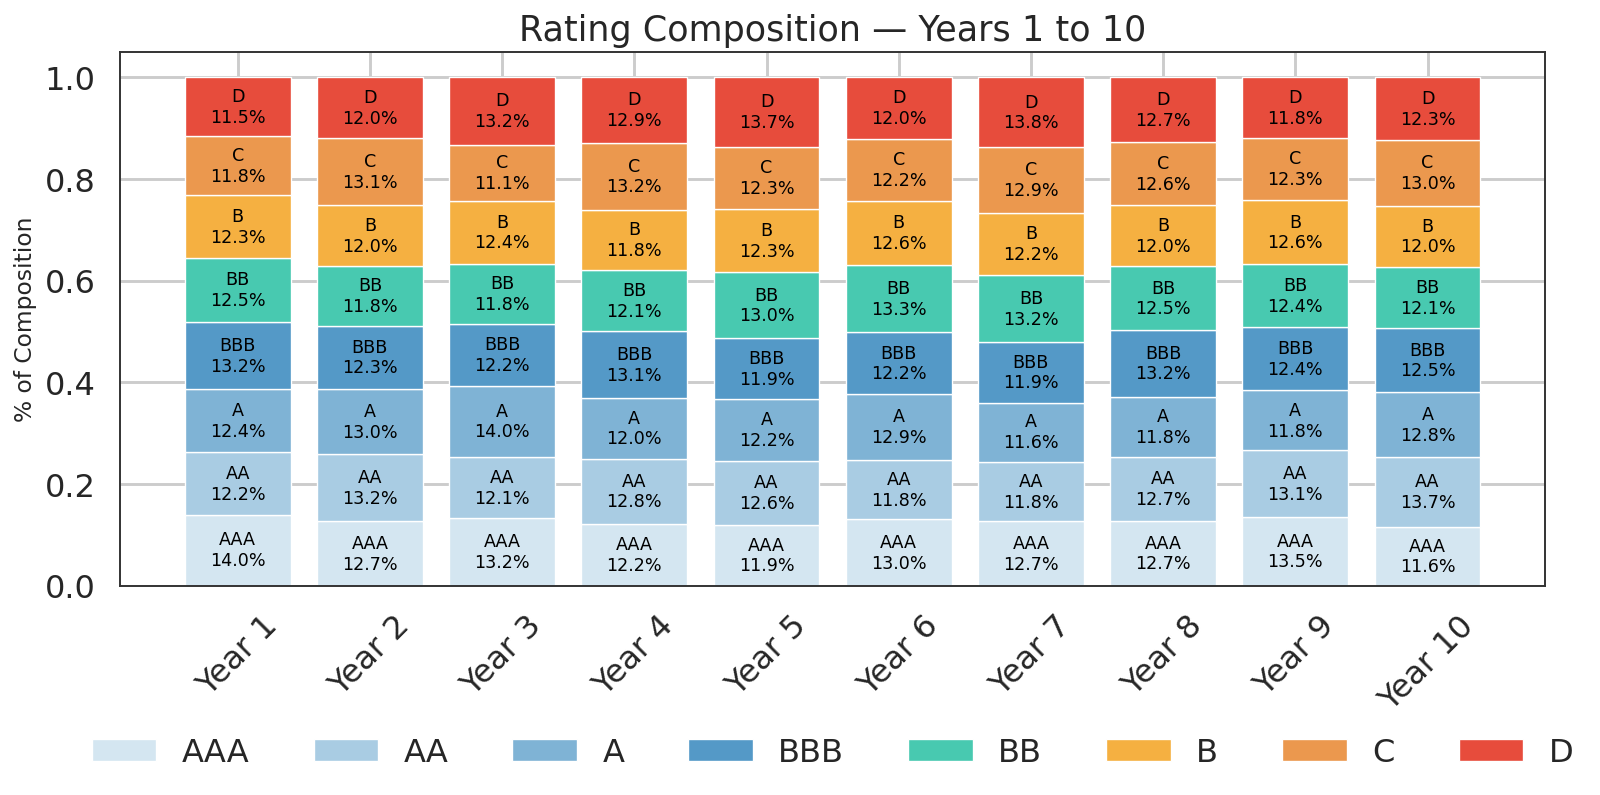


-> All Rating categories show comparable composition percentages, indicating an extremely diverse customer base


In [ ]:
years = list(ratings_df.columns)
composition = pd.DataFrame(index=years, columns=RATING_ORDER)

for y in years:
    composition.loc[y] = (
        ratings_df[y]
        .value_counts(normalize=True)
        .reindex(RATING_ORDER, fill_value=0)
        .values)

composition

fig, ax = plt.subplots(figsize=(12, 6))
bottom = np.zeros(len(years))

for rating in RATING_ORDER:
    vals = composition[rating].astype(float).values
    bars = ax.bar(
        years, vals,
        bottom=bottom,
        color=COLOR_MAP[rating],
        edgecolor="white",
        linewidth=0.7,
        label=rating)
    for bar, v in zip(bars, vals):
        if v > 0.01:
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                bar.get_y() + bar.get_height() / 2,
                f"{rating}\n{v*100:.1f}%",
                ha="center",
                va="center",
                color="black",
                fontsize=9,)
    bottom += vals

ax.set_title("Rating Composition — Years 1 to 10", fontsize=18)
ax.set_ylabel("% of Composition")
plt.xticks(rotation=45)

ax.legend(
    ncol=8,
    bbox_to_anchor=(0.5, -0.23),
    loc="upper center",
    frameon=False)

plt.tight_layout()
plt.show()

print("\n-> All Rating categories show comparable composition percentages, indicating an extremely diverse customer base")

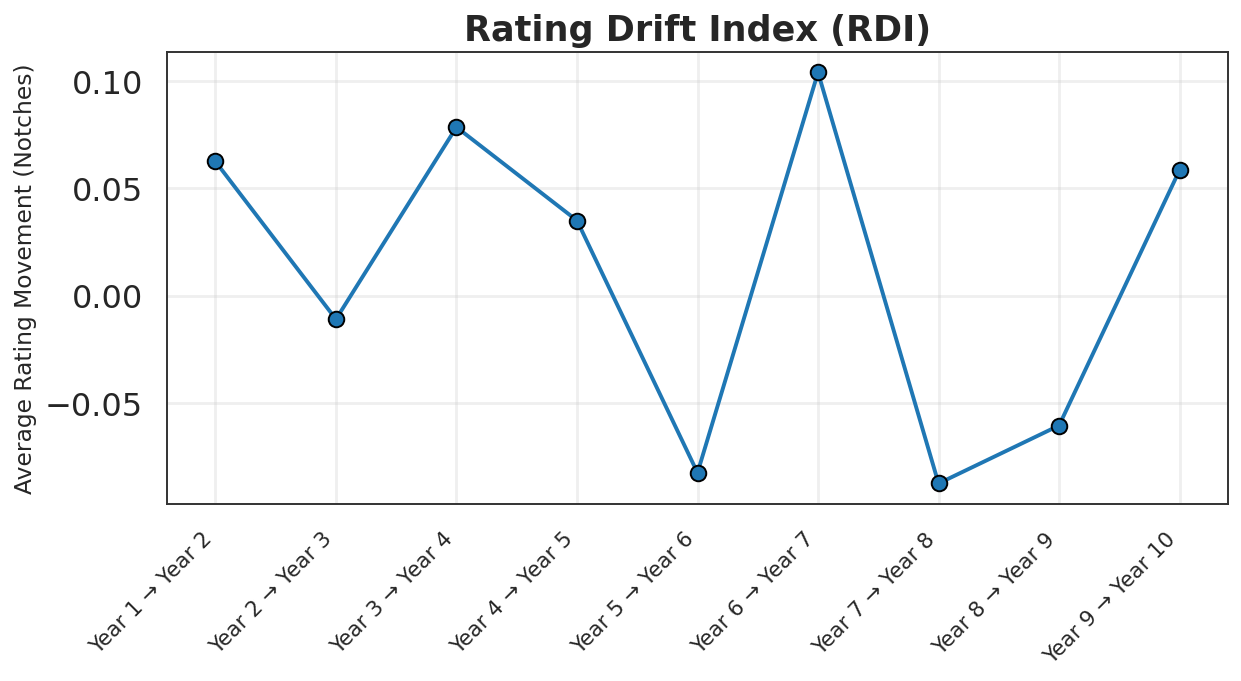


-> RDI fluctuates around zero, indicating that the portfolio experiences both upgrades
and downgrades, but without a long-term directional trend

-> The most notable swings are:
       Strong positive drift in Year 6 → Year 7 (largest improvement)
       Sharp negative drift in Year 5 → Year 6 and Year 7 → Year 8 (largest deterioration)



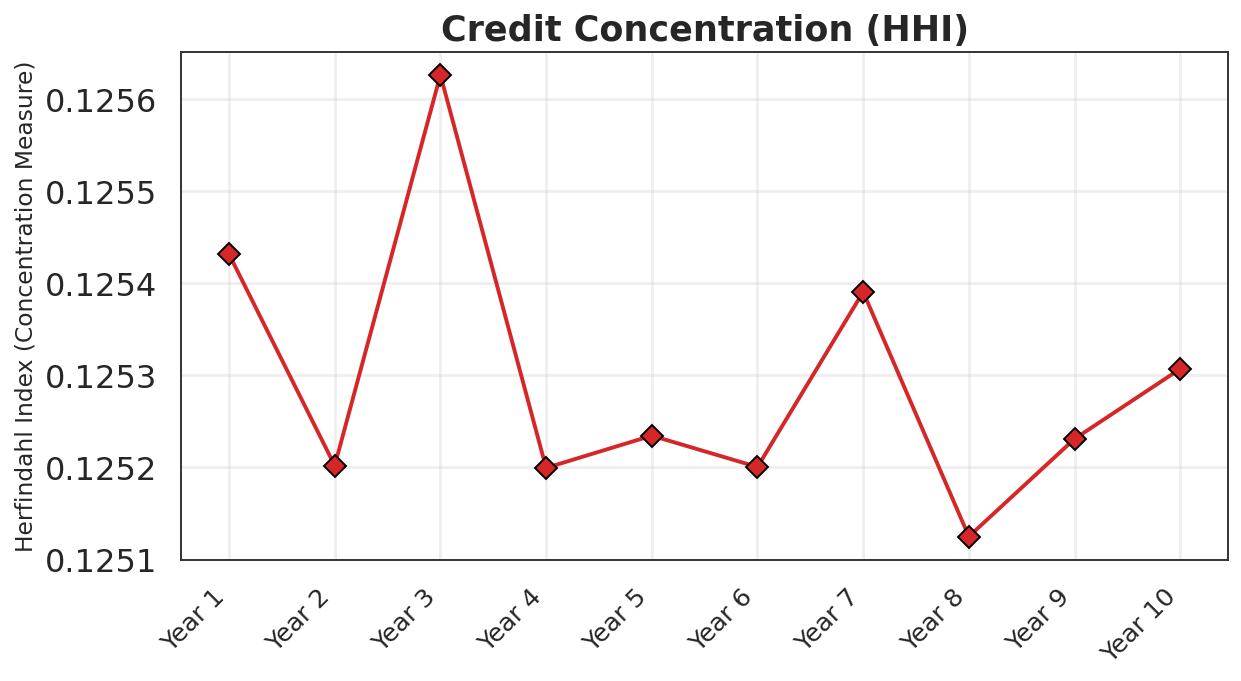


-> The Herfindahl–Hirschman Index (HHI) measures how concentrated the portfolio is across rating grades

-> Notable observations from HHI plot are:
       HHI remains extremely stable across all 10 years, staying within the narrow band 0.1251–0.1256


In [ ]:
rank_map = {r: i for i, r in enumerate(RATING_ORDER, start=1)}
rdi_vals = []
rdi_labels = []

for i in range(len(years) - 1):
    a = ratings_df[years[i]].map(rank_map)
    b = ratings_df[years[i+1]].map(rank_map)

    rdi_vals.append((b - a).mean())
    rdi_labels.append(f"{years[i]} → {years[i+1]}")

pd.DataFrame({"RDI": rdi_vals}, index=rdi_labels)

plt.figure(figsize=(9,5))
plt.plot(rdi_labels, rdi_vals, marker="o", linewidth=2, markersize=8,
         color="#1f77b4", markeredgecolor="black")

plt.title("Rating Drift Index (RDI)", fontsize=18, weight="bold")
plt.ylabel("Average Rating Movement (Notches)", fontsize=12)
plt.grid(alpha=0.3)
plt.xticks(rotation=45, ha='right', fontsize=11)
plt.tight_layout()
plt.show()

print("\n-> RDI fluctuates around zero, indicating that the portfolio experiences both upgrades")
print("and downgrades, but without a long-term directional trend")
print("")
print("-> The most notable swings are:")
print("       Strong positive drift in Year 6 → Year 7 (largest improvement)")
print("       Sharp negative drift in Year 5 → Year 6 and Year 7 → Year 8 (largest deterioration)")

hhi_vals = []

for y in years:
    dist = ratings_df[y].value_counts(normalize=True).reindex(RATING_ORDER, fill_value=0)
    hhi_vals.append((dist ** 2).sum())

pd.DataFrame({"HHI": hhi_vals}, index=years)
print("")

plt.figure(figsize=(9,5))
plt.plot(years, hhi_vals, marker="D", linewidth=2, markersize=8,
         color="#d62728", markeredgecolor="black")

plt.title("Credit Concentration (HHI)", fontsize=18, weight="bold")
plt.ylabel("Herfindahl Index (Concentration Measure)", fontsize=12)
plt.grid(alpha=0.3)
plt.xticks(rotation=45, ha='right', fontsize=13)
plt.tight_layout()
plt.show()

print("\n-> The Herfindahl–Hirschman Index (HHI) measures how concentrated the portfolio is across rating grades")
print("")
print("-> Notable observations from HHI plot are:")
print("       HHI remains extremely stable across all 10 years, staying within the narrow band 0.1251–0.1256")


=== Transition Matrix: Year 1 → Year 2 ===



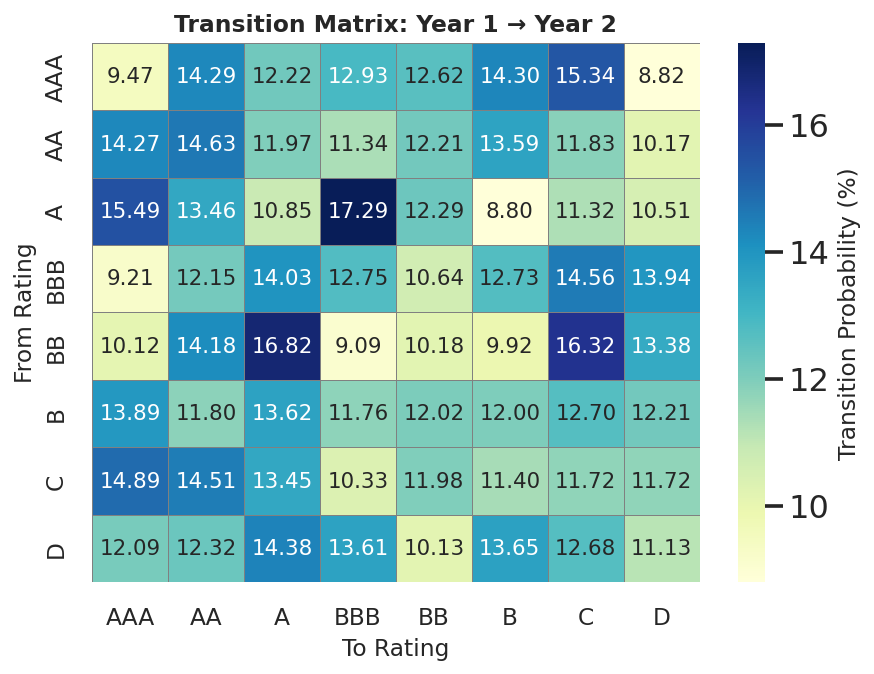


=== Transition Matrix: Year 2 → Year 3 ===



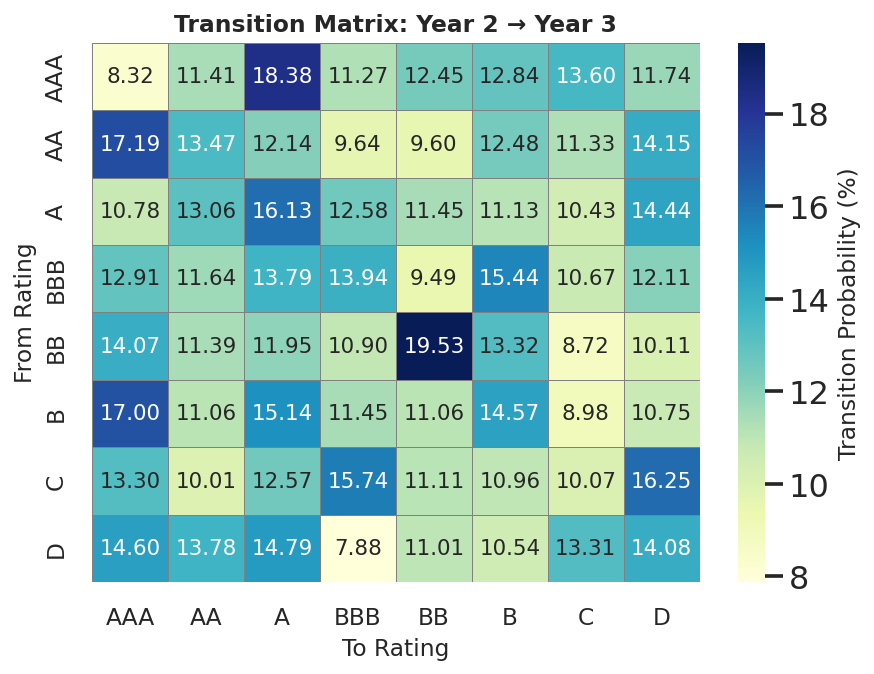


=== Transition Matrix: Year 3 → Year 4 ===



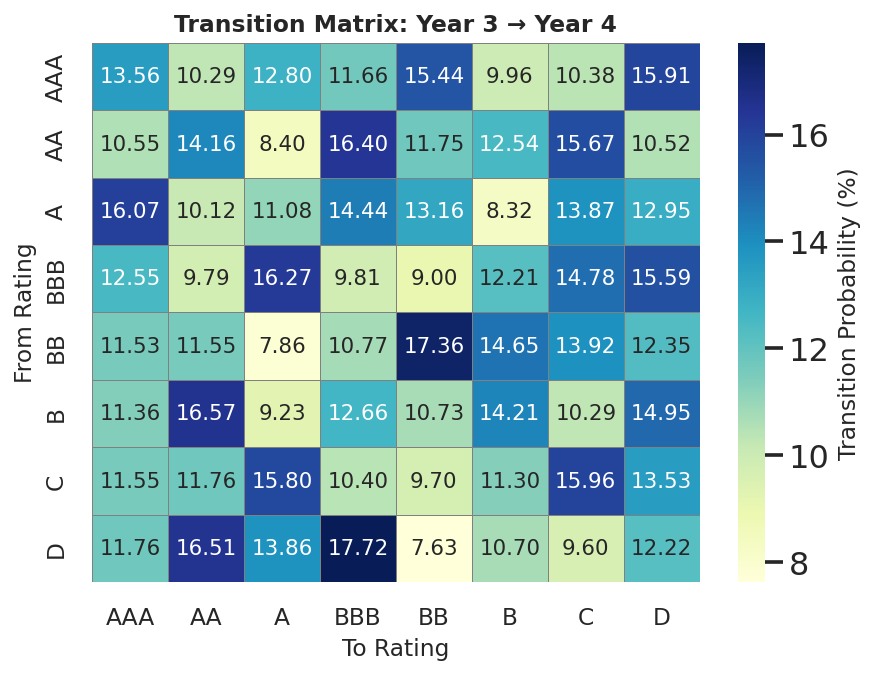


=== Transition Matrix: Year 4 → Year 5 ===



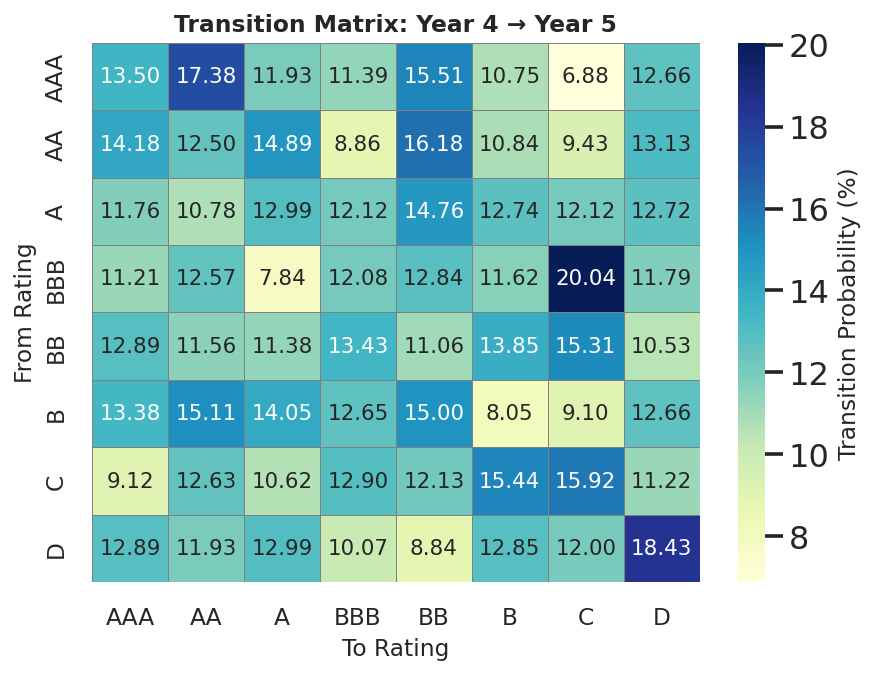


=== Transition Matrix: Year 5 → Year 6 ===



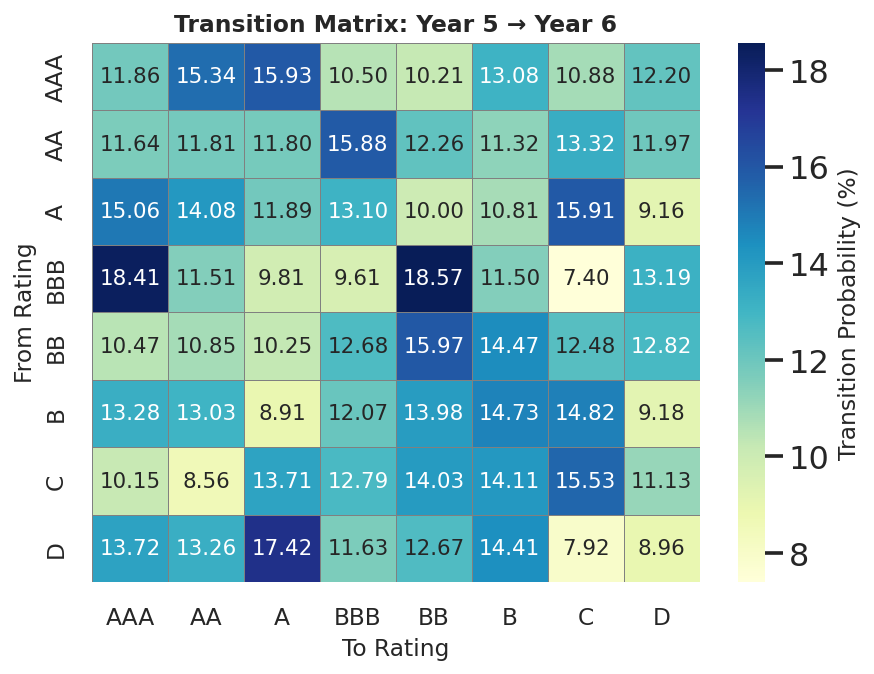


=== Transition Matrix: Year 6 → Year 7 ===



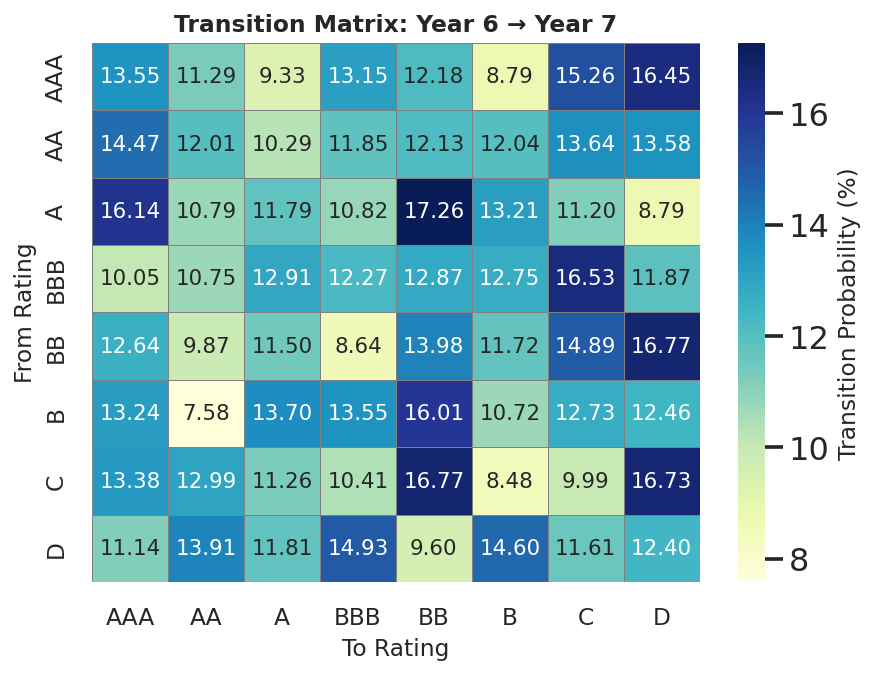


=== Transition Matrix: Year 7 → Year 8 ===



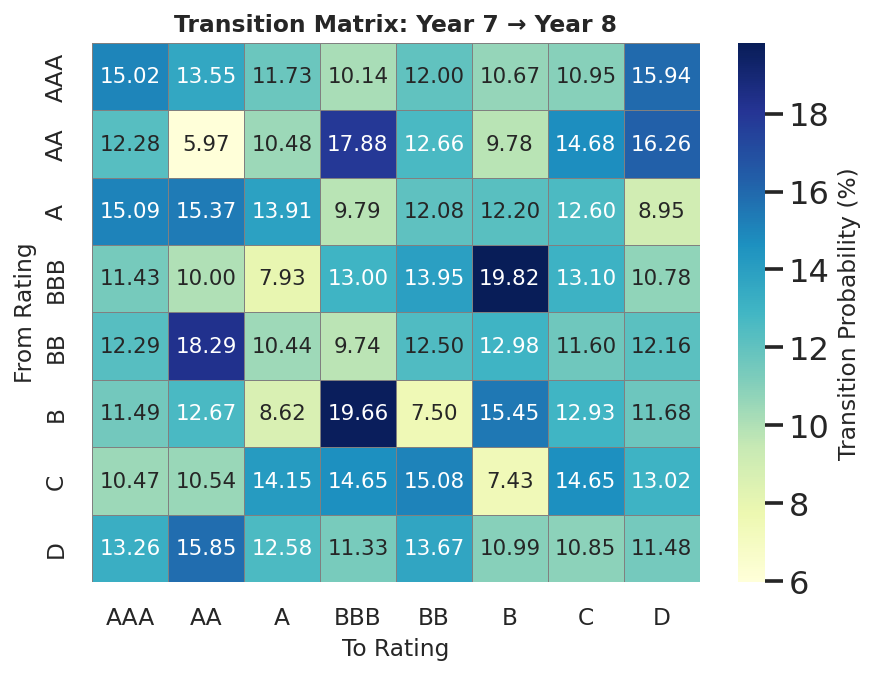


=== Transition Matrix: Year 8 → Year 9 ===



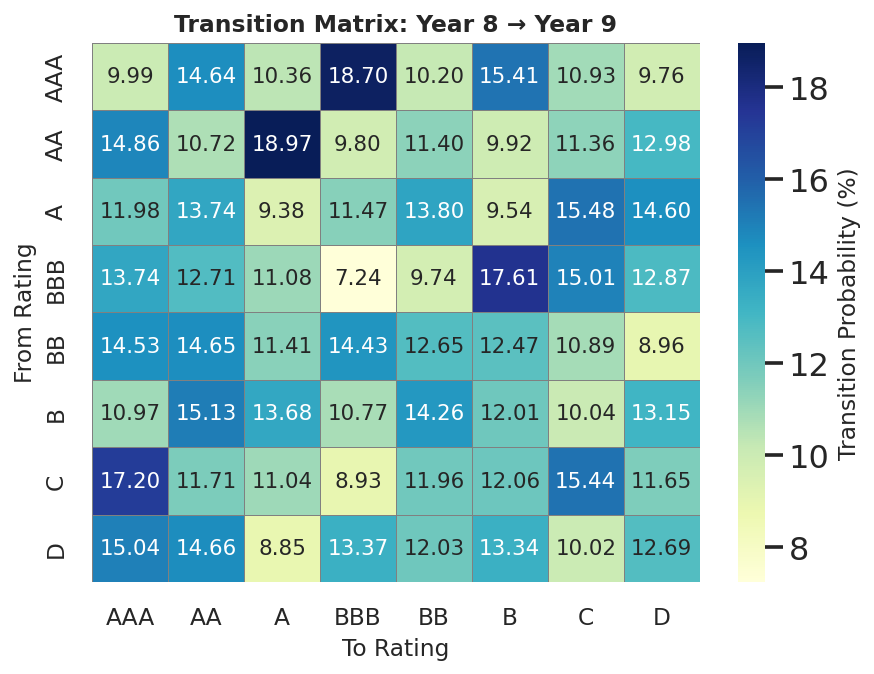


=== Transition Matrix: Year 9 → Year 10 ===



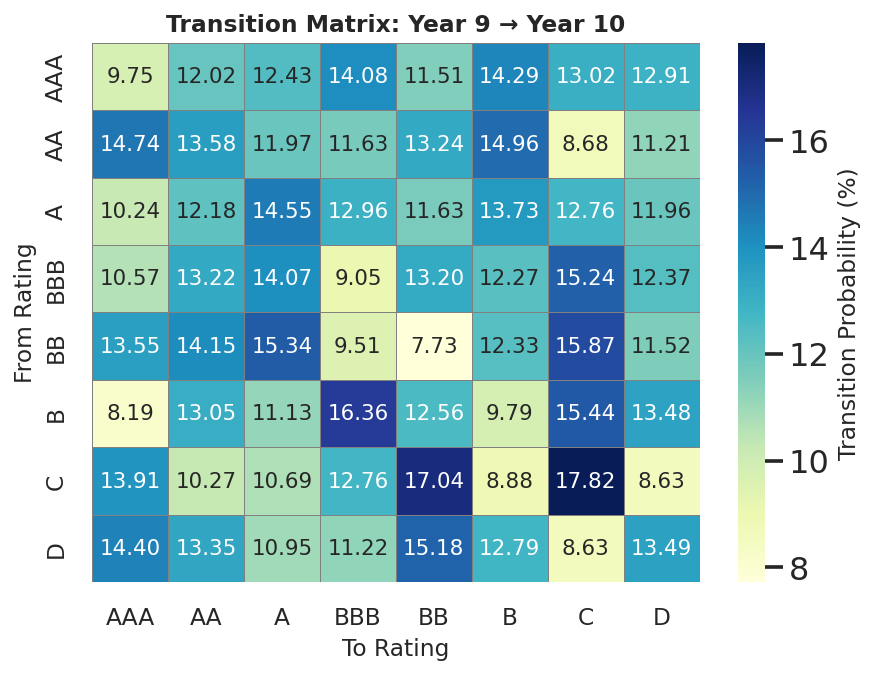


=== Overall Transition Heatmap - Year 1 vs Year 10 ===



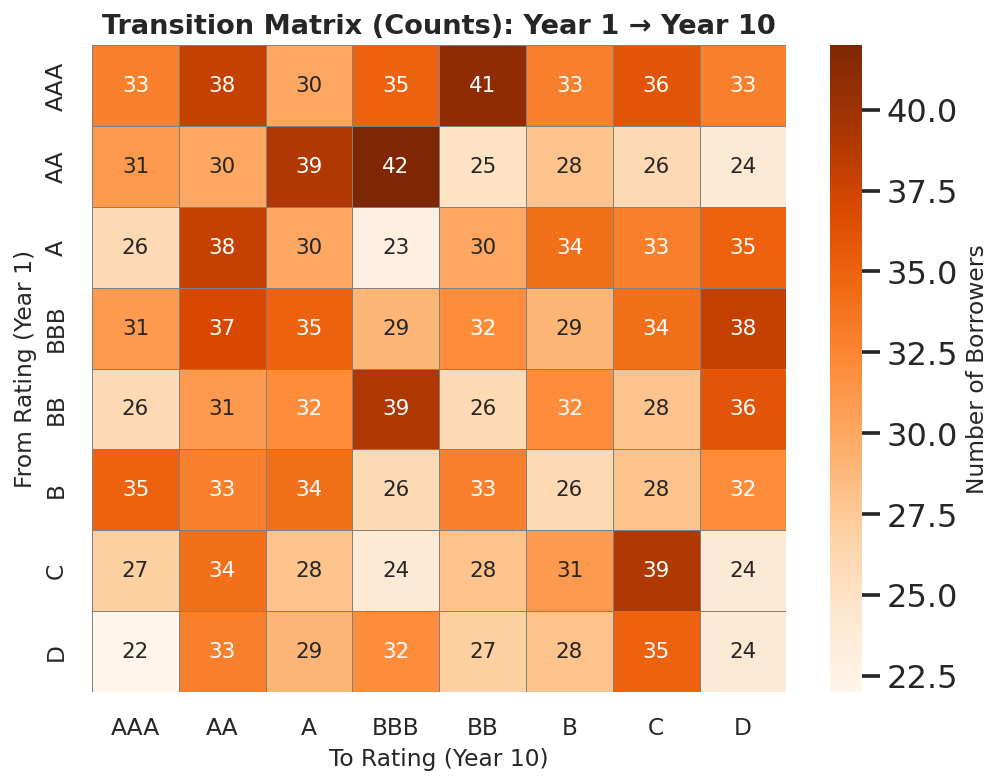


-> The strongest ratings (AAA & AA) show significant downgrade flows:
     AAA → BBB (35), AAA → BB (41), AAA → B (36)
     AA → BBB (42), AA → A (39), AA → BB/B (~25–28)

-> Moderate cross-movement within mid-tier ratings (A/BBB/BB)
     A → AA (38), A → B (34), A → D (35)
     BBB → AA (37), BBB → B (34), BBB → D (38)
     BB → BBB (39), BB → A/B (~30+ each)


In [ ]:
transition_matrices = []
years = list(ratings_df.columns)

for i in range(len(years) - 1):
    from_y, to_y = years[i], years[i+1]
    print(f"\n=== Transition Matrix: {from_y} → {to_y} ===\n")

    from_r = ratings_df[from_y]
    to_r   = ratings_df[to_y]
    ead_start = ead_df[from_y].astype(float)

    df_ead = pd.concat([
        from_r.rename("from"),
        to_r.rename("to"),
        ead_start.rename("ead")], axis=1).dropna()

    df_ead = df_ead[
        df_ead["from"].isin(RATING_ORDER) & df_ead["to"].isin(RATING_ORDER)]

    mat_ead = pd.DataFrame(0.0, index=RATING_ORDER, columns=RATING_ORDER)

    for f, t, e in zip(df_ead["from"], df_ead["to"], df_ead["ead"]):
        mat_ead.at[f, t] += float(e)

    probs = mat_ead.div(mat_ead.sum(axis=1).replace(0, np.nan), axis=0).fillna(0)
    transition_matrices.append(probs)

    plt.figure(figsize=(7,5))
    sns.heatmap(
        probs * 100, annot=True, cmap="YlGnBu", fmt=".2f",
        linewidths=.5, linecolor="gray",
        xticklabels=RATING_ORDER, yticklabels=RATING_ORDER,
        cbar_kws={"label": "Transition Probability (%)"})
    plt.xticks(fontsize=12, weight="medium")   # change X-axis label size
    plt.yticks(fontsize=12, weight="medium")

    plt.title(f"Transition Matrix: {from_y} → {to_y}", fontsize=12, weight="bold")
    plt.xlabel("To Rating")
    plt.ylabel("From Rating")
    plt.show()

print("\n=== Overall Transition Heatmap - Year 1 vs Year 10 ===\n")
start_year = years[0]
end_year   = years[-1]

from_r_full = ratings_df[start_year]
to_r_full   = ratings_df[end_year]

df_count = pd.concat([
    from_r_full.rename("from"),
    to_r_full.rename("to")], axis=1).dropna()

df_count = df_count[
    df_count["from"].isin(RATING_ORDER) &
    df_count["to"].isin(RATING_ORDER)]

count_mat = pd.DataFrame(0, index=RATING_ORDER, columns=RATING_ORDER)

for f, t in zip(df_count["from"], df_count["to"]):
    count_mat.at[f, t] += 1

plt.figure(figsize=(8, 6))
sns.heatmap(
    count_mat,
    annot=True,
    fmt="d",
    cmap="Oranges",
    linewidths=0.5,
    linecolor="gray",
    xticklabels=RATING_ORDER,
    yticklabels=RATING_ORDER,
    cbar_kws={"label": "Number of Borrowers"}
)

plt.title("Transition Matrix (Counts): Year 1 → Year 10", fontsize=14, weight="bold")
plt.xlabel("To Rating (Year 10)")
plt.ylabel("From Rating (Year 1)")
plt.xticks(fontsize=12, weight="medium")
plt.yticks(fontsize=12, weight="medium")
plt.show()

print("\n-> The strongest ratings (AAA & AA) show significant downgrade flows:")
print("     AAA → BBB (35), AAA → BB (41), AAA → B (36)")
print("     AA → BBB (42), AA → A (39), AA → BB/B (~25–28)")
print("\n-> Moderate cross-movement within mid-tier ratings (A/BBB/BB)")
print("     A → AA (38), A → B (34), A → D (35)")
print("     BBB → AA (37), BBB → B (34), BBB → D (38)")
print("     BB → BBB (39), BB → A/B (~30+ each)")



===== PD Calculation: Year 1 → Year 2 =====

 PD BY RATING CATEGORY:


,PD
AAA,0.0882
AA,0.1017
A,0.1051
BBB,0.1394
BB,0.1338
B,0.1221
C,0.1172
D,0.1113



 Portfolio PD for Year 1 → Year 2: **11.4342%**

===== PD Calculation: Year 2 → Year 3 =====

 PD BY RATING CATEGORY:


,PD
AAA,0.1174
AA,0.1415
A,0.1444
BBB,0.1211
BB,0.1011
B,0.1075
C,0.1625
D,0.1408



 Portfolio PD for Year 2 → Year 3: **12.9899%**

===== PD Calculation: Year 3 → Year 4 =====

 PD BY RATING CATEGORY:


,PD
AAA,0.1591
AA,0.1052
A,0.1295
BBB,0.1559
BB,0.1235
B,0.1495
C,0.1353
D,0.1222



 Portfolio PD for Year 3 → Year 4: **13.5402%**

===== PD Calculation: Year 4 → Year 5 =====

 PD BY RATING CATEGORY:


,PD
AAA,0.1266
AA,0.1313
A,0.1272
BBB,0.1179
BB,0.1053
B,0.1266
C,0.1122
D,0.1843



 Portfolio PD for Year 4 → Year 5: **12.9440%**

===== PD Calculation: Year 5 → Year 6 =====

 PD BY RATING CATEGORY:


,PD
AAA,0.1220
AA,0.1197
A,0.0916
BBB,0.1319
BB,0.1282
B,0.0918
C,0.1113
D,0.0896



 Portfolio PD for Year 5 → Year 6: **11.0805%**

===== PD Calculation: Year 6 → Year 7 =====

 PD BY RATING CATEGORY:


,PD
AAA,0.1645
AA,0.1358
A,0.0879
BBB,0.1187
BB,0.1677
B,0.1246
C,0.1673
D,0.1240



 Portfolio PD for Year 6 → Year 7: **13.6763%**

===== PD Calculation: Year 7 → Year 8 =====

 PD BY RATING CATEGORY:


,PD
AAA,0.1594
AA,0.1626
A,0.0895
BBB,0.1078
BB,0.1216
B,0.1168
C,0.1302
D,0.1148



 Portfolio PD for Year 7 → Year 8: **12.5672%**

===== PD Calculation: Year 8 → Year 9 =====

 PD BY RATING CATEGORY:


,PD
AAA,0.0976
AA,0.1298
A,0.1460
BBB,0.1287
BB,0.0896
B,0.1315
C,0.1165
D,0.1269



 Portfolio PD for Year 8 → Year 9: **12.0599%**

===== PD Calculation: Year 9 → Year 10 =====

 PD BY RATING CATEGORY:


,PD
AAA,0.1291
AA,0.1121
A,0.1196
BBB,0.1237
BB,0.1152
B,0.1348
C,0.0863
D,0.1349



 Portfolio PD for Year 9 → Year 10: **11.9529%**

=== FINAL PD SUMMARY TABLE ===


,Year 1→Year 2,Year 2→Year 3,Year 3→Year 4,Year 4→Year 5,Year 5→Year 6,Year 6→Year 7,Year 7→Year 8,Year 8→Year 9,Year 9→Year 10
AAA,0.0882,0.1174,0.1591,0.1266,0.1220,0.1645,0.1594,0.0976,0.1291
AA,0.1017,0.1415,0.1052,0.1313,0.1197,0.1358,0.1626,0.1298,0.1121
A,0.1051,0.1444,0.1295,0.1272,0.0916,0.0879,0.0895,0.1460,0.1196
BBB,0.1394,0.1211,0.1559,0.1179,0.1319,0.1187,0.1078,0.1287,0.1237
BB,0.1338,0.1011,0.1235,0.1053,0.1282,0.1677,0.1216,0.0896,0.1152
B,0.1221,0.1075,0.1495,0.1266,0.0918,0.1246,0.1168,0.1315,0.1348
C,0.1172,0.1625,0.1353,0.1122,0.1113,0.1673,0.1302,0.1165,0.0863
D,0.1113,0.1408,0.1222,0.1843,0.0896,0.1240,0.1148,0.1269,0.1349


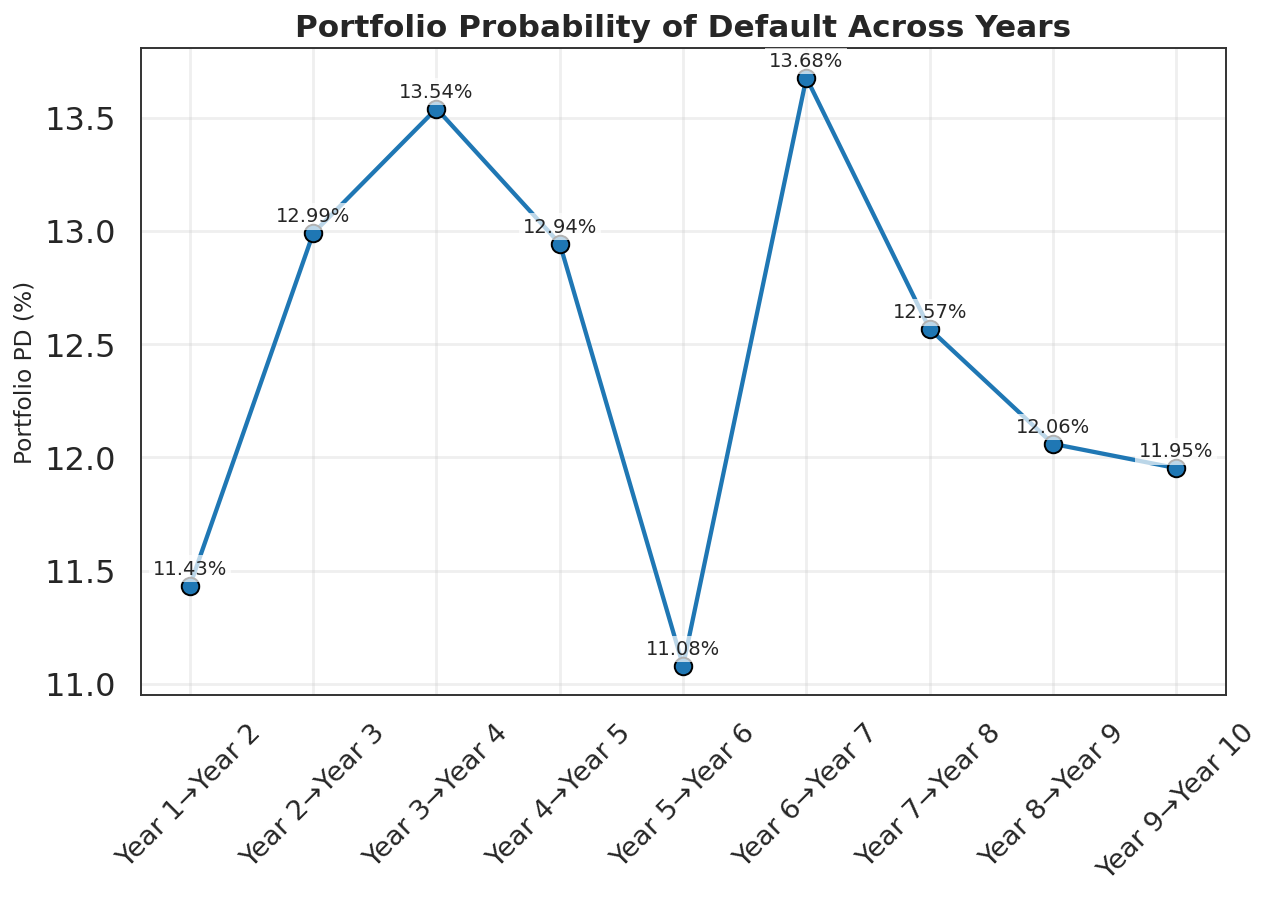


-> PD rises sharply in certain periods:
     Year 1 → Year 2: PD increases from 11.43% to 12.99%, suggesting a notable rise in risk early in the cycle
     Year 2 → Year 3: PD further rises to 13.54%, reinforcing the upward drift
-> Temporary Improvement in Credit Quality:
     Year 5 → Year 6: PD drops to the lowest point (11.08%)
-> Gradual Stabilization Toward the end:
     PD moderates from Year 7 → Year 10, declining from 12.57% → 11.95%

-> Overall Pattern:
      The PD curve forms an inverted “W-shape”:
         Rise → fall → spike → stabilisation


In [ ]:
pd_summary = pd.DataFrame(index=RATING_ORDER)
portfolio_pd = {}
years = list(ratings_df.columns)

for i in range(len(years) - 1):

    from_y, to_y = years[i], years[i+1]
    probs = transition_matrices[i]

    print(f"\n===== PD Calculation: {from_y} → {to_y} =====")
    pd_by_rating = probs[DEFAULT_LABEL]
    pd_summary[f"{from_y}→{to_y}"] = pd_by_rating

    print("\n PD BY RATING CATEGORY:")
    display(pd_by_rating.to_frame(name="PD").style.format("{:.4f}"))

    ead_start = ead_df[from_y].astype(float)
    from_r = ratings_df[from_y]

    merged = pd.concat([
        from_r.rename("rating"),
        ead_start.rename("ead")], axis=1).dropna()

    ead_sum = merged.groupby("rating")["ead"].sum().reindex(RATING_ORDER).fillna(0.0)

    portfolio_pd_val = float((pd_by_rating * ead_sum).sum() / ead_sum.sum())
    portfolio_pd[f"{from_y}→{to_y}"] = portfolio_pd_val

    print(f"\n Portfolio PD for {from_y} → {to_y}: **{portfolio_pd_val:.4%}**")

print("\n=== FINAL PD SUMMARY TABLE ===")
display(pd_summary.style.format("{:.4f}"))
print("\n")

transition_labels = list(portfolio_pd.keys())
portfolio_pd_values = [v * 100 for v in portfolio_pd.values()]

plt.figure(figsize=(10, 6))
plt.plot(
    transition_labels,
    portfolio_pd_values,
    marker="o",
    linewidth=2.2,
    color="#1f77b4",
    markeredgecolor="black"
)

plt.title("Portfolio Probability of Default Across Years", fontsize=16, weight="bold")
plt.ylabel("Portfolio PD (%)", fontsize=12)
plt.grid(alpha=0.3)

plt.xticks(rotation=45, fontsize=14)

for label, value in zip(transition_labels, portfolio_pd_values):
    plt.text(label, value + 0.05, f"{value:.2f}%", ha="center", fontsize=10, bbox=dict(
            facecolor="white",
            edgecolor="none",
            alpha=0.7,
            pad=2))
plt.show()

print("\n-> PD rises sharply in certain periods:")
print("     Year 1 → Year 2: PD increases from 11.43% to 12.99%, suggesting a notable rise in risk early in the cycle")
print("     Year 2 → Year 3: PD further rises to 13.54%, reinforcing the upward drift")
print("-> Temporary Improvement in Credit Quality:")
print("     Year 5 → Year 6: PD drops to the lowest point (11.08%)")
print("-> Gradual Stabilization Toward the end:")
print("     PD moderates from Year 7 → Year 10, declining from 12.57% → 11.95%")
print("\n-> Overall Pattern:\n      The PD curve forms an inverted “W-shape”:\n         Rise → fall → spike → stabilisation")


===== EL Calculation: Year 1 → Year 2 =====

 Portfolio EL for Year 1 → Year 2: **2,608.37 Cr**

 EL BY RATING CATEGORY (Rs Crore):


,EL
Start_Rating,
AAA,301.43
AA,272.74
A,315.25
BBB,390.45
BB,392.43
B,352.93
C,304.25
D,278.89



===== EL Calculation: Year 2 → Year 3 =====

 Portfolio EL for Year 2 → Year 3: **3,008.61 Cr**

 EL BY RATING CATEGORY (Rs Crore):


,EL
Start_Rating,
AAA,343.47
AA,428.02
A,456.32
BBB,364.18
BB,269.75
B,304.27
C,453.28
D,389.32



===== EL Calculation: Year 3 → Year 4 =====

 Portfolio EL for Year 3 → Year 4: **3,184.19 Cr**

 EL BY RATING CATEGORY (Rs Crore):


,EL
Start_Rating,
AAA,496.09
AA,287.55
A,404.57
BBB,458.87
BB,356.00
B,462.76
C,334.18
D,384.16



===== EL Calculation: Year 4 → Year 5 =====

 Portfolio EL for Year 4 → Year 5: **3,028.21 Cr**

 EL BY RATING CATEGORY (Rs Crore):


,EL
Start_Rating,
AAA,391.72
AA,419.43
A,354.82
BBB,369.52
BB,288.03
B,346.69
C,335.75
D,522.25



===== EL Calculation: Year 5 → Year 6 =====

 Portfolio EL for Year 5 → Year 6: **2,561.73 Cr**

 EL BY RATING CATEGORY (Rs Crore):


,EL
Start_Rating,
AAA,349.41
AA,365.33
A,255.71
BBB,373.21
BB,369.34
B,258.36
C,320.39
D,269.97



===== EL Calculation: Year 6 → Year 7 =====

 Portfolio EL for Year 6 → Year 7: **3,118.00 Cr**

 EL BY RATING CATEGORY (Rs Crore):


,EL
Start_Rating,
AAA,465.71
AA,392.74
A,240.49
BBB,344.67
BB,529.02
B,341.19
C,451.26
D,352.92



===== EL Calculation: Year 7 → Year 8 =====

 Portfolio EL for Year 7 → Year 8: **2,917.81 Cr**

 EL BY RATING CATEGORY (Rs Crore):


,EL
Start_Rating,
AAA,515.12
AA,450.05
A,217.26
BBB,295.87
BB,360.83
B,335.11
C,361.51
D,382.07



===== EL Calculation: Year 8 → Year 9 =====

 Portfolio EL for Year 8 → Year 9: **2,721.89 Cr**

 EL BY RATING CATEGORY (Rs Crore):


,EL
Start_Rating,
AAA,265.29
AA,382.99
A,402.80
BBB,376.59
BB,270.48
B,360.32
C,350.76
D,312.66



===== EL Calculation: Year 9 → Year 10 =====

 Portfolio EL for Year 9 → Year 10: **2,699.83 Cr**

 EL BY RATING CATEGORY (Rs Crore):


,EL
Start_Rating,
AAA,380.12
AA,333.87
A,328.85
BBB,335.91
BB,300.41
B,397.52
C,250.66
D,372.50




=== FINAL EL SUMMARY TABLE (Rs Crore) ===


,Year 1→Year 2,Year 2→Year 3,Year 3→Year 4,Year 4→Year 5,Year 5→Year 6,Year 6→Year 7,Year 7→Year 8,Year 8→Year 9,Year 9→Year 10
AAA,301.43,343.47,496.09,391.72,349.41,465.71,515.12,265.29,380.12
AA,272.74,428.02,287.55,419.43,365.33,392.74,450.05,382.99,333.87
A,315.25,456.32,404.57,354.82,255.71,240.49,217.26,402.80,328.85
BBB,390.45,364.18,458.87,369.52,373.21,344.67,295.87,376.59,335.91
BB,392.43,269.75,356.00,288.03,369.34,529.02,360.83,270.48,300.41
B,352.93,304.27,462.76,346.69,258.36,341.19,335.11,360.32,397.52
C,304.25,453.28,334.18,335.75,320.39,451.26,361.51,350.76,250.66
D,278.89,389.32,384.16,522.25,269.97,352.92,382.07,312.66,372.50


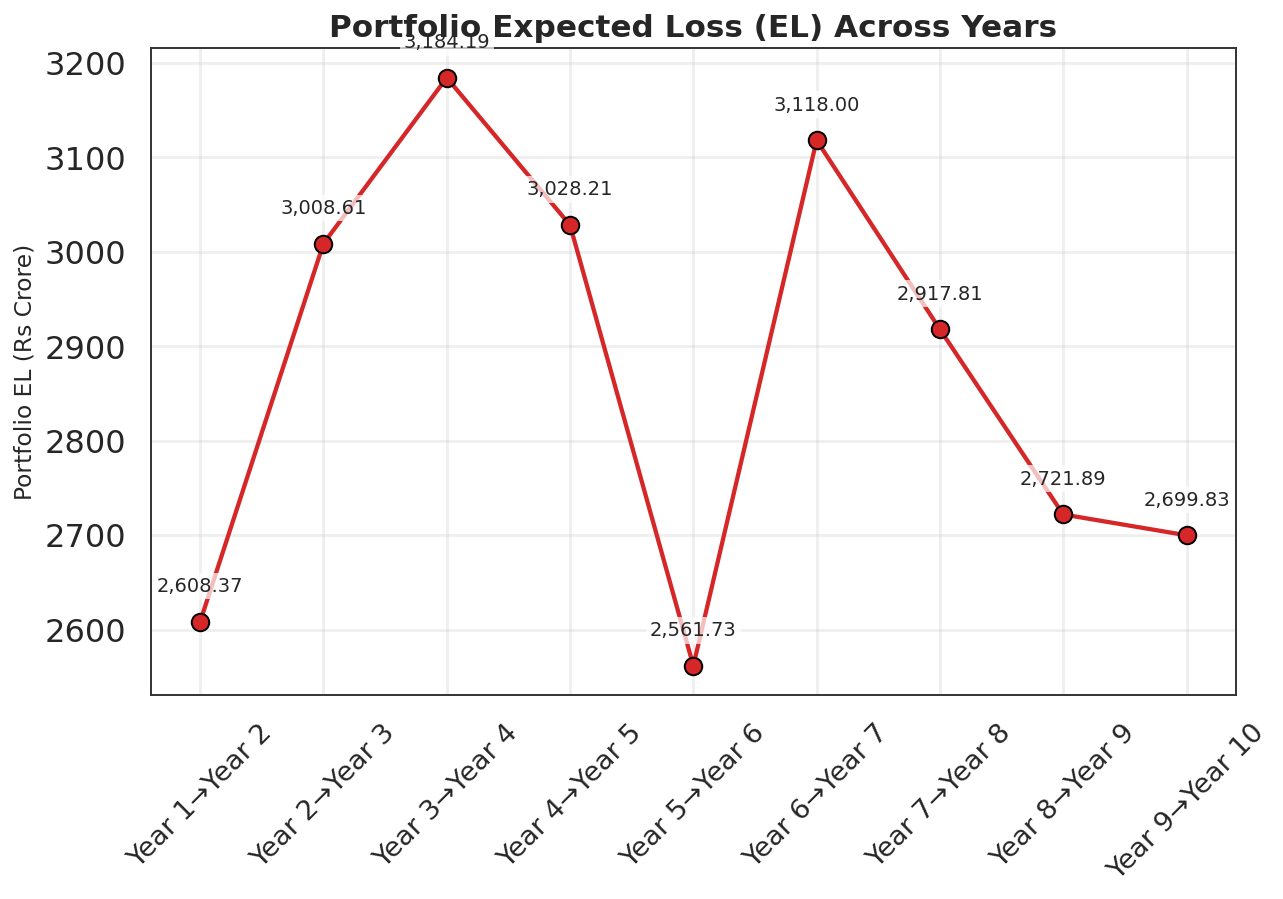


Interpretation: Portfolio Expected Loss (EL) Across Years:
-> EL fluctuates across the decade, showing two major spikes:
      Year 3→4 (highest deterioration)
      Year 6→7 (second deterioration)
-> Two periods of improvement:
      Year 4→5 to Year 5→6
      Final years (Year 7→8 onwards)
-> This suggests:
      Credit quality is cyclical
      Sensitivity to migrations is significant,
      The portfolio is vulnerable to specific deterioration windows rather than a steady decline.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

portfolio_el_summary = {}
el_summary = pd.DataFrame(index=RATING_ORDER)
years = list(ratings_df.columns)

for i in range(len(years) - 1):
    from_y, to_y = years[i], years[i+1]
    tm = transition_matrices[i]
    print(f"\n===== EL Calculation: {from_y} → {to_y} =====")

    df_trans = pd.DataFrame({
        'Start_Rating': ratings_df[from_y],
        'EAD': ead_df[from_y].astype(float),
        'LGD': lgd_df[to_y].astype(float)}).dropna()

    pd_mapping = tm[DEFAULT_LABEL].to_dict()
    df_trans['PD_Borrower'] = df_trans['Start_Rating'].map(pd_mapping)
    df_trans['EL_Borrower'] = df_trans['PD_Borrower'] * df_trans['LGD'] * df_trans['EAD']
    portfolio_el_val = df_trans['EL_Borrower'].sum()
    portfolio_el_summary[f"{from_y}→{to_y}"] = portfolio_el_val

    print(f"\n Portfolio EL for {from_y} → {to_y}: **{portfolio_el_val:,.2f} Cr**")
    el_by_rating = df_trans.groupby('Start_Rating')['EL_Borrower'].sum().reindex(RATING_ORDER).fillna(0.0)
    el_summary[f"{from_y}→{to_y}"] = el_by_rating

    print("\n EL BY RATING CATEGORY (Rs Crore):")
    display(el_by_rating.to_frame(name="EL").style.format("{:,.2f}"))

print("\n\n=== FINAL EL SUMMARY TABLE (Rs Crore) ===")
display(el_summary.style.format("{:,.2f}"))

transition_labels = list(portfolio_el_summary.keys())
portfolio_el_values = list(portfolio_el_summary.values())
print("\n")

plt.figure(figsize=(10, 6))
plt.plot(
    transition_labels,
    portfolio_el_values,
    marker="o",
    linewidth=2.2,
    color="#d62728",
    markeredgecolor="black"
)

plt.title("Portfolio Expected Loss (EL) Across Years", fontsize=16, weight="bold")
plt.ylabel("Portfolio EL (Rs Crore)", fontsize=12)
plt.grid(alpha=0.3)

plt.xticks(rotation=45, fontsize=14)

for label, value in zip(transition_labels, portfolio_el_values):
    offset = max(portfolio_el_values) * 0.01 if portfolio_el_values else 0.05
    plt.text(label, value + offset, f"{value:,.2f}", ha="center", fontsize=10, bbox=dict(
            facecolor="white",
            edgecolor="none",
            alpha=0.7,
            pad=2))

plt.show()
print("\nInterpretation: Portfolio Expected Loss (EL) Across Years:")
print("-> EL fluctuates across the decade, showing two major spikes:")
print("      Year 3→4 (highest deterioration)")
print("      Year 6→7 (second deterioration)")
print("-> Two periods of improvement:")
print("      Year 4→5 to Year 5→6")
print("      Final years (Year 7→8 onwards)")
print("-> This suggests:")
print("      Credit quality is cyclical")
print("      Sensitivity to migrations is significant,")
print("      The portfolio is vulnerable to specific deterioration windows rather than a steady decline.")


,CPD_5
AAA,0.408905
AA,0.400540
A,0.418299
BBB,0.436859
BB,0.389428
B,0.417991
C,0.432453
D,0.453271


Portfolio CPD (Year 5): 41.8879%



,CPD_10
AAA,0.713544
AA,0.704927
A,0.670078
BBB,0.706542
BB,0.686535
B,0.692868
C,0.705079
D,0.708425


Portfolio CPD (Year 10): 69.8458%



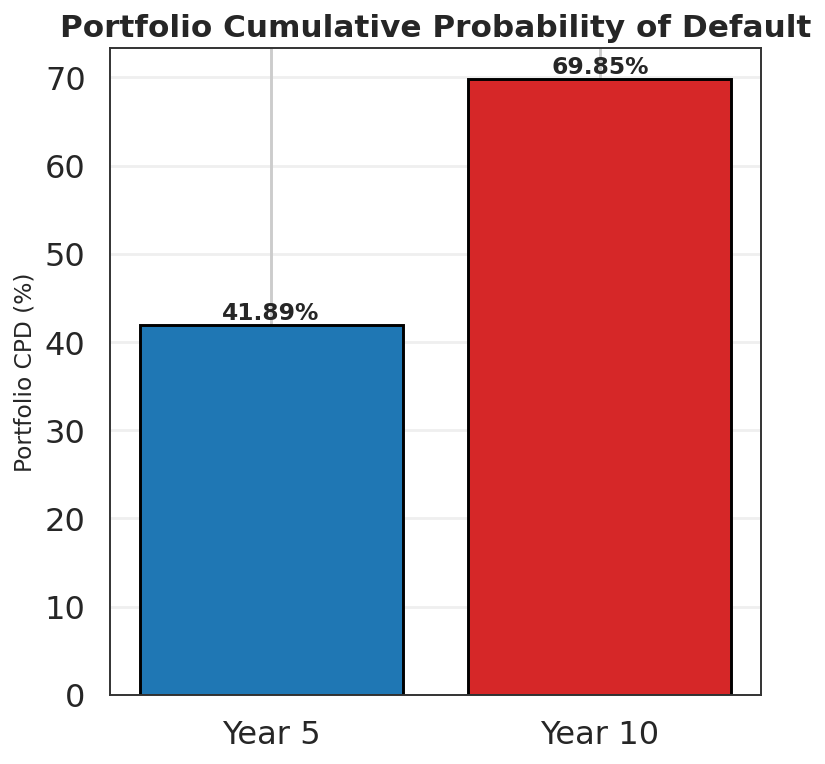


-> CPD increases significantly over time:
      Year 5 CPD ≈ 41.89%
      Year 10 CPD ≈ 69.85%

-> This indicates that:
      By Year 5, roughly 42% of the portfolio is expected to have defaulted cumulatively
      By Year 10, nearly 70% of the portfolio is expected to default at least once within the 10-year horizon


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

initial_year = years[0]
initial_ratings = ratings_df[initial_year]
initial_ead = ead_df[initial_year]

merged_init = pd.concat([
    initial_ratings.rename("rating"),
    initial_ead.rename("ead")], axis=1).dropna()

ead_by_rating = (
    merged_init.groupby("rating")["ead"]
    .sum()
    .reindex(RATING_ORDER)
    .fillna(0))

total_ead = ead_by_rating.sum()

targets = [5, 10]
cpd_results = {}

for T in targets:
    one_year_pds = []
    for i in range(T - 1):
        tm = transition_matrices[i]
        one_year_pds.append(tm[DEFAULT_LABEL])
    survival = pd.Series(1.0, index=RATING_ORDER)
    for pd_series in one_year_pds:
        survival *= (1 - pd_series)
    cpd_by_rating = 1 - survival
    portfolio_cpd = float((cpd_by_rating * ead_by_rating).sum() / total_ead)
    cpd_results[f"Portfolio{T}"] = portfolio_cpd
    display(cpd_by_rating.to_frame(name=f"CPD_{T}"))
    print(f"Portfolio CPD (Year {T}): {portfolio_cpd:.4%}\n")

portfolio_vals = [cpd_results["Portfolio5"] * 100,
                  cpd_results["Portfolio10"] * 100]

fig, ax = plt.subplots(figsize=(6, 6))
bars = ax.bar(["Year 5", "Year 10"], portfolio_vals,
              color=["#1f77b4", "#d62728"], edgecolor="black")

ax.set_ylabel("Portfolio CPD (%)", fontsize=12)
ax.set_title("Portfolio Cumulative Probability of Default", fontsize=16, weight="bold")

for bar in bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height + 0.1,
        f"{height:.2f}%",
        ha="center", va="bottom", fontsize=12, weight="bold")

plt.grid(axis="y", alpha=0.3)
plt.show()

print("\n-> CPD increases significantly over time:")
print("      Year 5 CPD ≈ 41.89%")
print("      Year 10 CPD ≈ 69.85%")
print("\n-> This indicates that:")
print("      By Year 5, roughly 42% of the portfolio is expected to have defaulted cumulatively")
print("      By Year 10, nearly 70% of the portfolio is expected to default at least once within the 10-year horizon")

LGD stress: Portfolio EL (Normal vs LGD-stressed) by transition


,Normal EL,Stressed EL (LGD),Increase (%)
Year 1→Year 2,"2,608.37","3,522.76",35.06%
Year 2→Year 3,"3,008.61","4,178.01",38.87%
Year 3→Year 4,"3,184.19","3,801.48",19.39%
Year 4→Year 5,"3,028.21","3,755.52",24.02%
Year 5→Year 6,"2,561.73","3,259.77",27.25%
Year 6→Year 7,"3,118.00","3,935.17",26.21%
Year 7→Year 8,"2,917.81","3,990.41",36.76%
Year 8→Year 9,"2,721.89","3,762.04",38.21%
Year 9→Year 10,"2,699.83","3,635.65",34.66%


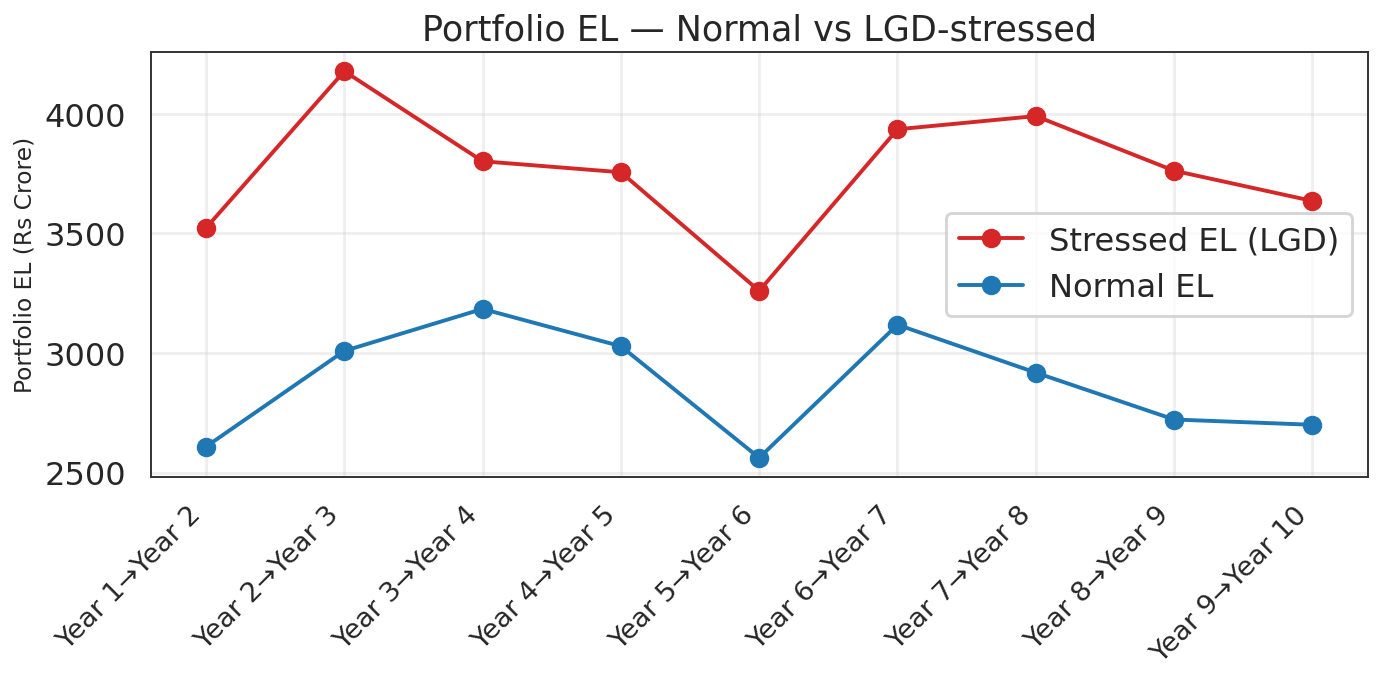


-> Stressed EL is consistently higher than Normal EL

-> The gap between Normal and Stressed EL varies across years:
      Largest jumps: Year 2→3, Year 6→7, and Year 7→8
      Smaller jumps: Year 5→6 and Year 9→10


In [ ]:
#STRESS SCENARIO ..(i) - LGD Multiplier

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

transition_keys = [f"{years[i]}→{years[i+1]}" for i in range(len(years)-1)]
stressed_el_lgd = {}
normal_el_series = pd.Series({k: portfolio_el_summary.get(k, 0.0) for k in transition_keys}, index=transition_keys)

for i, key in enumerate(transition_keys):
    from_y, to_y = years[i], years[i+1]
    try:
        start_num = int(from_y.split()[-1])
    except:
        start_num = i + 1
    end_year_num = start_num + 1

    multiplier = LGD_MULTIPLIERS_BY_YEAR.get(end_year_num, 1.0)

    df_trans = pd.DataFrame({
        'Start_Rating': ratings_df[from_y],
        'EAD': ead_df[from_y].astype(float),
        'LGD_Normal': lgd_df[to_y].astype(float)}).dropna()

    df_trans['LGD_Stressed'] = (df_trans['LGD_Normal'] * multiplier).clip(upper=1.0) #capping the multiplier at 1.0

    tm = transition_matrices[i]
    pd_mapping = tm[DEFAULT_LABEL].to_dict()

    df_trans['PD_Borrower'] = df_trans['Start_Rating'].map(pd_mapping)

    df_trans['EL_Stressed_Borrower'] = df_trans['PD_Borrower'] * df_trans['LGD_Stressed'] * df_trans['EAD']

    stressed_el_total = df_trans['EL_Stressed_Borrower'].sum()
    stressed_el_lgd[key] = stressed_el_total

comparison_df = pd.DataFrame({
    "Normal EL": normal_el_series,
    "Stressed EL (LGD)": pd.Series(stressed_el_lgd),}).fillna(0.0)

comparison_df["Increase (%)"] = ((comparison_df["Stressed EL (LGD)"] / comparison_df["Normal EL"]).replace([np.inf, -np.inf], np.nan) - 1) * 100
comparison_df["Increase (%)"] = comparison_df["Increase (%)"].fillna(0.0)

print("LGD stress: Portfolio EL (Normal vs LGD-stressed) by transition")
display(comparison_df.style.format({"Normal EL":"{:,.2f}", "Stressed EL (LGD)":"{:,.2f}", "Increase (%)":"{:.2f}%"}))
print("\n")
plt.figure(figsize=(10,5))
x = np.arange(len(comparison_df.index))

plt.plot(x, comparison_df["Stressed EL (LGD)"].values, marker='o', label='Stressed EL (LGD)', linewidth=2, color='#d62728')
plt.plot(x, comparison_df["Normal EL"].values, marker='o', label='Normal EL', linewidth=2, color='#1f77b4')

plt.xticks(x, comparison_df.index, rotation=45, ha='right', fontsize=14)
plt.ylabel("Portfolio EL (Rs Crore)")
plt.title("Portfolio EL — Normal vs LGD-stressed")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()

plt.savefig("lgd_stress_comparison.png")
plt.show()

print("\n-> Stressed EL is consistently higher than Normal EL")
print("\n-> The gap between Normal and Stressed EL varies across years:")
print("      Largest jumps: Year 2→3, Year 6→7, and Year 7→8")
print("      Smaller jumps: Year 5→6 and Year 9→10")


Stressed Portfolio PD: 25.2303%
Stressed Portfolio EL: 5,710.76 Cr


,Scenario,Portfolio EL (Cr),Increase (%)
0,Normal EL,"2,699.83",0.000000
1,Stressed EL,"5,710.76",111.522617


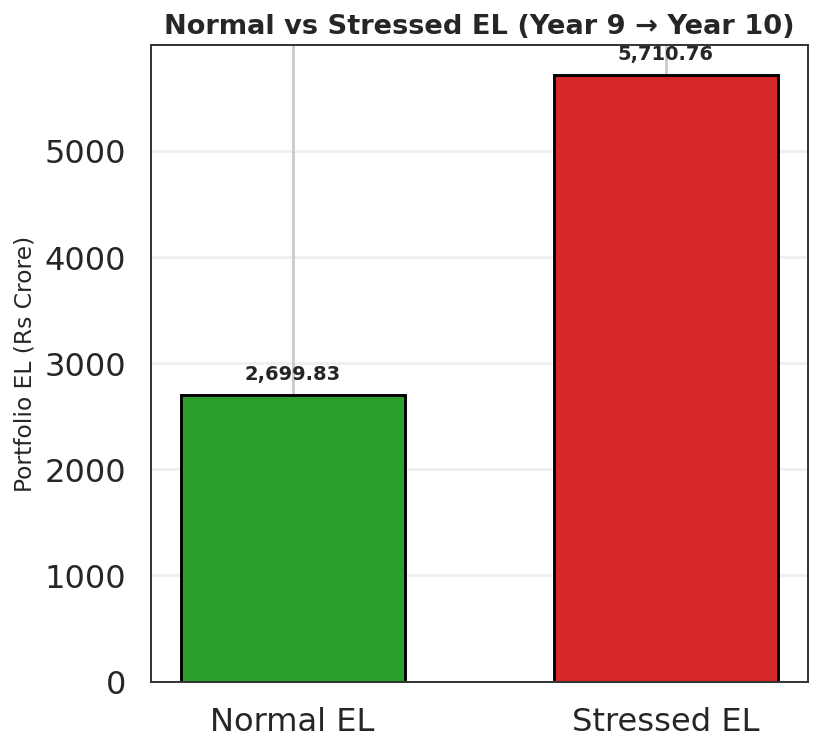


-> Stressed EL is more than double the Normal EL
      Normal EL: ₹2,699.83 Cr; Stressed EL: ₹5,710.76 Cr
      A staggering increase of ~ 112%

-> This sharp jump reflects the sensitivity of the portfolio to systematic rating deterioration


In [ ]:
#STRESS SCENARIO ..(ii) - Year 10 Rating Transition

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from_y = None
to_y = None
for i in range(len(years)-1):
    if "year 9" in years[i].lower() or years[i].strip() == "9":
        from_y = years[i]
        to_y = years[i+1]
        break

if from_y is None:
    from_y, to_y = years[-2], years[-1]

key = f"{from_y}→{to_y}"

ratings_stress_df = ratings_df.copy()
ratings_stress_df[to_y] = ratings_stress_df[from_y].map(RATING_DOWNGRADE_MAP).fillna(DEFAULT_LABEL)

df_ead_stress = pd.concat([
    ratings_stress_df[from_y].rename("from"),
    ratings_stress_df[to_y].rename("to"),
    ead_df[from_y].astype(float).rename("ead")], axis=1).dropna()
df_ead_stress = df_ead_stress[df_ead_stress["from"].isin(RATING_ORDER) & df_ead_stress["to"].isin(RATING_ORDER)]

tm_stress_counts = pd.crosstab(
    df_ead_stress["from"],
    df_ead_stress["to"],
    values=df_ead_stress["ead"],
    aggfunc="sum").reindex(index=RATING_ORDER, columns=RATING_ORDER).fillna(0.0)

tm_stress_probs = tm_stress_counts.div(tm_stress_counts.sum(axis=1).replace(0, np.nan), axis=0).fillna(0.0)
pd_stressed_series = tm_stress_probs[DEFAULT_LABEL]

ead_sum_by_rating = df_ead_stress.groupby("from")["ead"].sum().reindex(RATING_ORDER).fillna(0.0)

portfolio_pd_stressed = (pd_stressed_series * ead_sum_by_rating).sum() / ead_sum_by_rating.sum()
portfolio_pd_stressed_pct = portfolio_pd_stressed * 100

print(f"\nStressed Portfolio PD: {portfolio_pd_stressed_pct:.4f}%")

df_calc_stress = pd.DataFrame({
    'Start_Rating': ratings_stress_df[from_y],
    'EAD': ead_df[from_y].astype(float),
    'LGD': lgd_df[to_y].astype(float)}).dropna()

pd_mapping_stress = pd_stressed_series.to_dict()
df_calc_stress['PD_Stressed'] = df_calc_stress['Start_Rating'].map(pd_mapping_stress)
df_calc_stress['EL_Stressed'] = df_calc_stress['PD_Stressed'] * df_calc_stress['LGD'] * df_calc_stress['EAD']
portfolio_el_stressed_val = df_calc_stress['EL_Stressed'].sum()

print(f"Stressed Portfolio EL: {portfolio_el_stressed_val:,.2f} Cr")

normal_el_val = portfolio_el_summary.get(key, 0.0)

summary_b = pd.DataFrame({
    "Scenario": ["Normal EL", "Stressed EL"],
    "Portfolio EL (Cr)": [normal_el_val, portfolio_el_stressed_val]})
summary_b["Increase (%)"] = [0, ((portfolio_el_stressed_val - normal_el_val)/normal_el_val)*100]
display(summary_b.style.format({"Portfolio EL (Cr)":"{:,.2f}", "Increase":"{:,.2f}"}))

plt.figure(figsize=(6, 5.5))
bars = plt.bar(
    summary_b["Scenario"],
    summary_b["Portfolio EL (Cr)"],
    color=["#2ca02c", "#d62728"],
    edgecolor="black",
    width=0.6)

plt.ylabel("Portfolio EL (Rs Crore)", fontsize=12)
plt.title(f"Normal vs Stressed EL ({from_y} → {to_y})", fontsize=14, weight="bold")
plt.grid(axis="y", alpha=0.3)

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2.,
        height + (max(summary_b["Portfolio EL (Cr)"])*0.02),
        f"{height:,.2f}",
        ha='center', va='bottom', fontsize=10, weight="semibold")

plt.tight_layout()
plt.show()

print("\n-> Stressed EL is more than double the Normal EL")
print("      Normal EL: ₹2,699.83 Cr; Stressed EL: ₹5,710.76 Cr")
print("      A staggering increase of ~ 112%")
print("\n-> This sharp jump reflects the sensitivity of the portfolio to systematic rating deterioration")

=== Rating Stability (Higher = More Stable) ===


,Stability
C,0.1412
BB,0.1344
D,0.1276
A,0.1251
B,0.1239
AA,0.1209
AAA,0.1167
BBB,0.1108


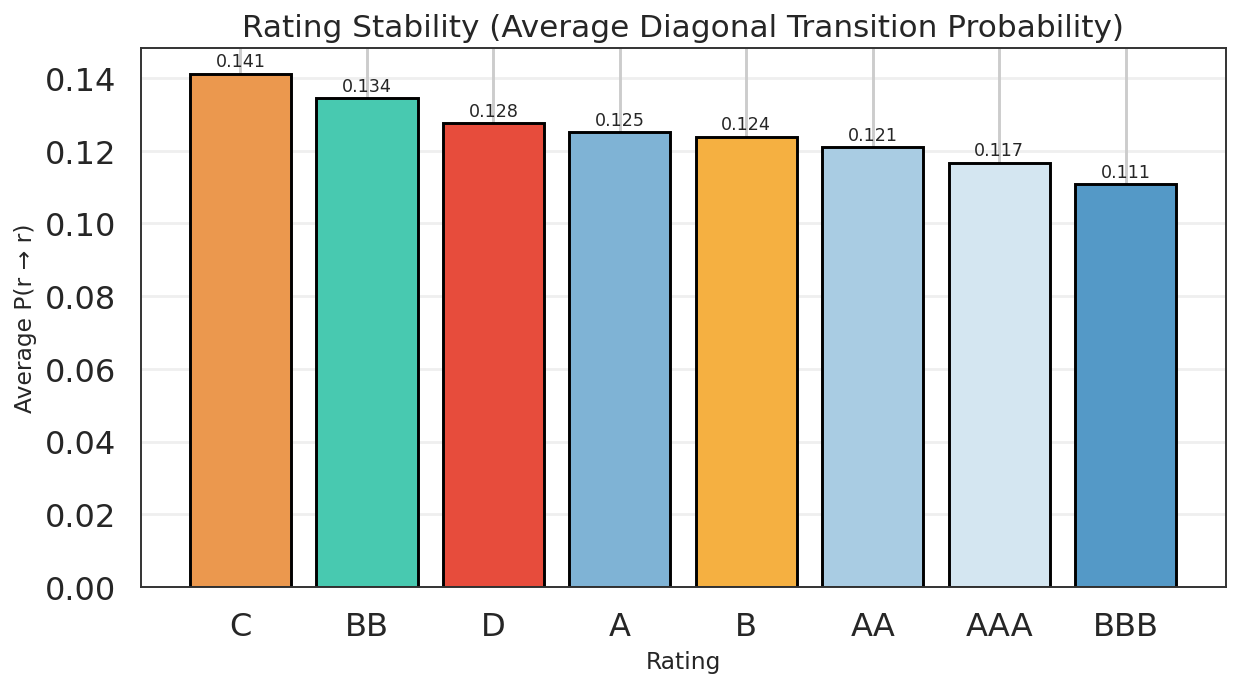


Most Stable Rating Category: **C** with an average “stay probability” of around 0.141

-> BB (~0.134) and D (~0.128) also show relatively high stability
     For BB, this suggests that mid-speculative borrowers maintain their credit profile for multiple years
     For D, it reflects the expected behaviour—defaults typically remain in default unless cured, which is rare


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

stability_scores = {}

for rating in RATING_ORDER:
    diag_probs = []
    for mat in transition_matrices:
        diag_probs.append(mat.loc[rating, rating])
    stability_scores[rating] = np.mean(diag_probs)

stability_df = pd.DataFrame.from_dict(
    stability_scores, orient='index', columns=["Stability"]).sort_values("Stability", ascending=False)

print("=== Rating Stability (Higher = More Stable) ===")
display(stability_df.style.format("{:.4f}"))

plt.figure(figsize=(10, 5))
plt.bar(stability_df.index, stability_df["Stability"],
        color=[COLOR_MAP[r] for r in stability_df.index], edgecolor="black")

plt.title("Rating Stability (Average Diagonal Transition Probability)", fontsize=16)
plt.ylabel("Average P(r → r)")
plt.xlabel("Rating")
plt.grid(axis="y", alpha=0.3)
for i, val in enumerate(stability_df["Stability"]):
    plt.text(i, val + 0.002, f"{val:.3f}", ha="center", fontsize=9)
plt.show()

most_stable = stability_df["Stability"].idxmax()
print(f"\nMost Stable Rating Category: **{most_stable}** with an average “stay probability” of around 0.141")

print("\n-> BB (~0.134) and D (~0.128) also show relatively high stability")
print("     For BB, this suggests that mid-speculative borrowers maintain their credit profile for multiple years")
print("     For D, it reflects the expected behaviour—defaults typically remain in default unless cured, which is rare")

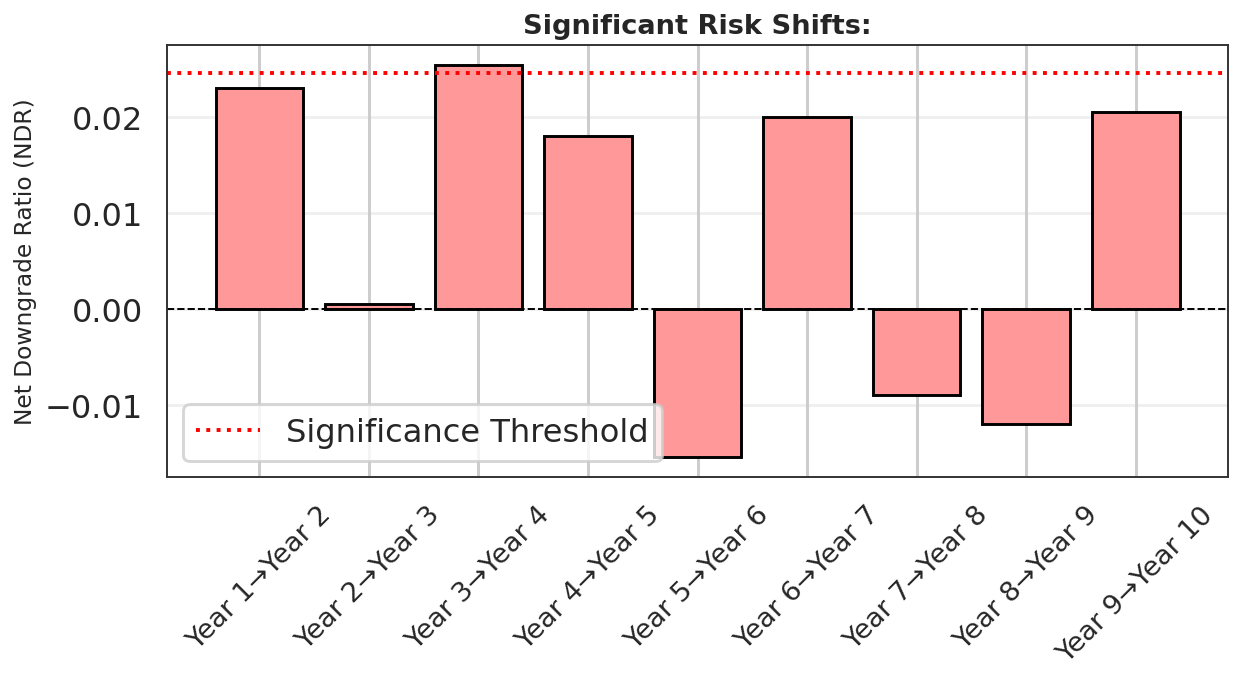


Significant Rating Shift Periods:
    Year 3→Year 4 (NDR = 0.0255)

Interpretation:
• Positive NDR = more downgrades → credit deterioration
• Negative NDR = more upgrades → credit improvement
• Significant shifts = NDR > (Mean + 1st SD)


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

ndr_values = []
ndr_labels = []

for i in range(len(years) - 1):
    y1, y2 = years[i], years[i+1]

    start = ratings_df[y1]
    end = ratings_df[y2]

    upgrades = 0
    downgrades = 0

    for r1, r2 in zip(start, end):
        if r1 in RATING_ORDER and r2 in RATING_ORDER:
            if RATING_ORDER.index(r2) < RATING_ORDER.index(r1):
                upgrades += 1
            elif RATING_ORDER.index(r2) > RATING_ORDER.index(r1):
                downgrades += 1

    total = len(start)
    ndr = (downgrades - upgrades) / total

    ndr_values.append(ndr)
    ndr_labels.append(f"{y1}→{y2}")

ndr_series = pd.Series(ndr_values, index=ndr_labels)

mean_ndr = ndr_series.mean()
std_ndr  = ndr_series.std()

threshold = mean_ndr + std_ndr

significant_shifts = ndr_series[ndr_series > threshold]

plt.figure(figsize=(9,5))
plt.bar(ndr_series.index, ndr_series.values,
        color="#ff9999", edgecolor="black")

plt.axhline(0, color="black", linestyle="--", linewidth=1)
plt.axhline(threshold, color="red", linestyle=":", linewidth=2,
            label="Significance Threshold")

plt.ylabel("Net Downgrade Ratio (NDR)", fontsize=12)
plt.title("Significant Risk Shifts:", fontsize=14, weight="bold")

plt.xticks(rotation=45, fontsize=14)
plt.grid(axis='y', alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

print("\nSignificant Rating Shift Periods:")
for idx, val in significant_shifts.items():
  print(f"    {idx} (NDR = {val:.4f})")

print("\nInterpretation:")
print("• Positive NDR = more downgrades → credit deterioration")
print("• Negative NDR = more upgrades → credit improvement")
print("• Significant shifts = NDR > (Mean + 1st SD)")